<h1>Reinforcement Learning</h1>

In [1]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as mplt
import datetime
import shap
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings("ignore")

<h1>Using all the Data to Predict Demand and solar</h1>

In [3]:
weather_all= pd.read_csv('weather.csv')
demand_all = pd.read_csv('demand.csv')
solar_all  = pd.read_csv('solar.csv')

In [359]:
weather_all = weather[weather['train'].isin(['train','test'])]
demand_all  = demand[demand['train'].isin(['train','test'])]
solar_all   = solar[solar['train'].isin(['train','test'])]

weather_all = weather_all.iloc[96:]
demand_all  = demand_all.iloc[96:]
solar_all   = solar_all.iloc[96:]

weather_all.shape, demand_all.shape, solar_all.shape

((12480, 18), (12480, 9), (12480, 11))

In [360]:
Y_demand = demand_all['demand_MW']
X_demand = pd.DataFrame.copy(weather_all)

X_demand['last_hour']      = demand_all['last_hour'].values
X_demand['last_day']       = demand_all['last_day'].values
X_demand['last_hour_mean'] = demand_all['last_hour_mean'].values
X_demand['last_day_mean']  = demand_all['last_day_mean'].values
del X_demand['train']

xgb_demand = xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators = 100,colsample_bytree = 0.85, learning_rate = 0.1,
                max_depth = 11, alpha = 5, seed = 123)   
xgb_demand.fit(X_demand, Y_demand) 
pred = xgb_demand.predict(X_demand) 

rmse = metrics.r2_score(Y_demand, pred) 
print("RMSE : % f" %(rmse))

RMSE :  0.998777


In [361]:
Y_solar = solar_all['pv_power_mw']
X_solar = pd.DataFrame.copy(weather_all)

X_solar['last_hour']      = solar_all['last_hour'].values
X_solar['last_day']       = solar_all['last_day'].values
X_solar['last_hour_mean'] = solar_all['last_hour_mean'].values
X_solar['last_day_mean']  = solar_all['last_day_mean'].values
del X_solar['train']

xgb_solar = xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators = 200,colsample_bytree = 0.75, learning_rate = 0.2,
                max_depth = 8, alpha = 30, seed = 3) 
xgb_solar.fit(X_solar, Y_solar) 
pred = xgb_solar.predict(X_solar) 

rmse = metrics.r2_score(Y_solar, pred) 
print("RMSE : % f" %(rmse), X_solar.shape)

RMSE :  0.999290 (12480, 21)


<h1>predicting demand and load</h1>

In [390]:
def predict():
    weather = pd.read_csv('weather.csv')
    del weather['train']
    demand  = pd.read_csv('demand.csv')
    solar   = pd.read_csv('solar.csv')
    
    gg = []
    
    for D in range(7):
        d = 7-D
        for t in range(48):
            X_d = np.zeros((len(X_demand.columns),1))
            wc  = len(weather.columns)
            X_d[0:wc,0:1] = weather.iloc[-(48*d-t)].values.reshape(-1,1)
            X_d[wc,0]   = demand['demand_MW'].iloc[-(48*d-t+2)]
            X_d[wc+1,0] = demand['demand_MW'].iloc[-(48*d-t+48)]
            X_d[wc+2,0] = np.mean(demand['demand_MW'].iloc[-(48*d-t+4):-(48*d-t+0)].values)
            X_d[wc+3,0] = np.mean(demand['demand_MW'].iloc[-(48*d-t+72):-(48*d-t+24)].values)
            
            
            X_p = np.zeros((len(X_solar.columns),1))
            wc  = len(weather.columns)
            X_p[0:wc,0:1] = weather.iloc[-(48*d-t)].values.reshape(-1,1)
            X_p[wc,0]   = solar['pv_power_mw'].iloc[-(48*d-t+2)]
            X_p[wc+1,0] = solar['pv_power_mw'].iloc[-(48*d-t+48)]
            X_p[wc+2,0] = np.mean(solar['pv_power_mw'].iloc[-(48*d-t+4):-(48*d-t+0)].values)
            X_p[wc+3,0] = np.mean(solar['pv_power_mw'].iloc[-(48*d-t+72):-(48*d-t+24)].values)
            
            gg.append(X_p)
            
            X_d = pd.DataFrame(X_d.T,columns=X_demand.columns)
            X_p = pd.DataFrame(X_p.T,columns=X_solar.columns)
            
            demand['demand_MW'].iloc[-(48*d-t)]  = max(0,xgb_demand.predict(X_d)[0])
            solar['pv_power_mw'].iloc[-(48*d-t)] = max(0,xgb_solar.predict(X_p)[0])
            
    '''
    gg = np.array(gg).reshape(336,21)
    #print(gg.shape)
    gg = pd.DataFrame(gg,columns=X_solar.columns)
    print(np.mean(gg))
    fig = mplt.figure(figsize=(18,6))
    mplt.subplot(2,1,1)
    mplt.plot(gg['solar_location3'])
    mplt.subplot(2,1,2)
    mplt.plot(solar['pv_power_mw'].iloc[-48*7:].values)
    '''
    
    return(demand,solar)

In [391]:
demand, solar = predict();

<h1>optimizing function for a day</h1>

In [392]:
W = pd.read_csv('weather.csv')
D = pd.read_csv('demand.csv')
S = pd.read_csv('solar.csv')

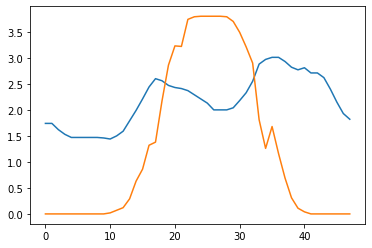

In [393]:
load = list(D['demand_MW'].iloc[-49-48*7:-1-48*7].values)
pv   = list(S['pv_power_mw'].iloc[-49-48*7:-1-48*7].values)
mplt.plot(load)
mplt.plot(pv);

In [255]:
import gurobipy as gp
from gurobipy import GRB

1.2974932044699485 1.0 0.5675022651766838 1.708181818181818


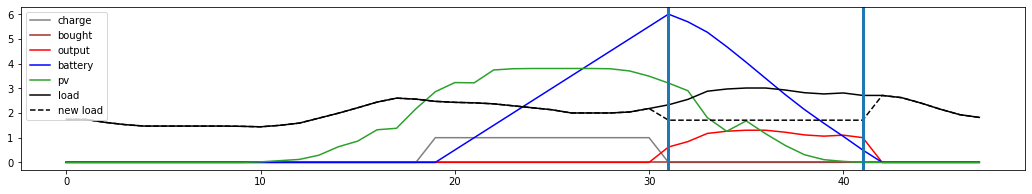

In [394]:
def optimize_day(load,pv,day):
    
    model = gp.Model("dailySchedule")
    model.setParam('OutputFlag', False)
    model.setParam('NonConvex', 2)
    
    rate = 2.5
    peak = max(load[31:42])
    capacity = 6
    
    charge = [model.addVar(0,rate,0,GRB.CONTINUOUS,'charge'+str(t+1)) for t in range(48)]
    bought = [model.addVar(0,rate,0,GRB.CONTINUOUS,'bought'+str(t+1)) for t in range(48)]
    Input  = [model.addVar(0,rate,0,GRB.CONTINUOUS,'input'+str(t+1)) for t in range(48)]
    
    Output = [model.addVar(0,rate,0,GRB.CONTINUOUS,'output'+str(t+1)) for t in range(48)]
    
    Store  = [model.addVar(0,capacity,0,GRB.CONTINUOUS,'capacity'+str(t+1)) for t in range(48)]
    
    numerator   = model.addVar(0,GRB.INFINITY,0,GRB.CONTINUOUS,'numerator')
    denominator = model.addVar(0,GRB.INFINITY,0,GRB.CONTINUOUS,'denominator')
    
    sum_num = gp.LinExpr()
    sum_num.addTerms(-1,numerator)
    sum_den = gp.LinExpr()
    sum_den.addTerms(-1,denominator)
    
    PE = model.addVar(0,GRB.INFINITY,0,GRB.CONTINUOUS,'PE')
    
    
    for t in range(48):
        model.addLConstr(charge[t]+bought[t], GRB.EQUAL,Input[t])
        model.addLConstr(charge[t],GRB.LESS_EQUAL,pv[t])
        
        if t < 31:
            model.addLConstr(Output[t], GRB.EQUAL,0)
            sum_num.addTerms(1,charge[t])
            sum_den.addTerms(1,charge[t])
            sum_den.addTerms(1,bought[t])
            
        elif t > 30 and t < 42:
            model.addLConstr(Input[t], GRB.EQUAL,0)
            
            maxP = gp.LinExpr()
            maxP.addTerms(1,PE)
            maxP.addTerms(1,Output[t])
            model.addLConstr(maxP,GRB.GREATER_EQUAL,load[t])
            
        else:
            model.addLConstr(Input[t], GRB.EQUAL,0)
            model.addLConstr(Output[t], GRB.EQUAL,0)
            
        if t == 0:
            model.addLConstr(Store[t],GRB.EQUAL,0)
            
        else:
            battery = gp.LinExpr()
            battery.addTerms(1,Store[t])
            battery.addTerms(-1,Store[t-1])
            battery.addTerms(-0.5,Input[t-1])
            battery.addTerms(0.5,Output[t-1])
            model.addLConstr(battery,GRB.EQUAL,0)
            
    model.addLConstr(sum_num,GRB.EQUAL,0)
    model.addLConstr(sum_den,GRB.EQUAL,0)
    
    p = model.addVar(0,1,0,GRB.CONTINUOUS,'p')
    model.addQConstr(p*denominator,GRB.EQUAL,numerator)
    
    r = model.addVar(0,1,0,GRB.CONTINUOUS,'p')
    model.addLConstr(r*peak,GRB.EQUAL,PE)
    
    model.setObjective(1+2*p-r-2*r*p, GRB.MAXIMIZE)
    model.optimize()
    
    print(model.objVal,p.x,r.x,PE.x)
    
    charge_list = [round(charge[t].x,4) for t in range(48)]
    bought_list = [round(bought[t].x,4) for t in range(48)]
    Input_list  = [round(Input[t].x,4) for t in range(48)]
    Output_list = [round(Output[t].x,4) for t in range(48)]
    Store_list  = [round(Store[t].x,4) for t in range(48)]
    
    new_load    = [load[t]-Output[t].x for t in range(48)]
    flag = 1

    if flag == 1:
        fig = mplt.figure(figsize=(18,3))
        mplt.plot(charge_list,c='grey',label='charge')
        mplt.plot(bought_list,c='brown',label='bought')
        mplt.plot(Output_list,c='r',label='output')
        mplt.plot(Store_list,c='b',label='battery')
        mplt.plot(pv,c='tab:green',label='pv')
        mplt.plot(load,c='black',label='load')
        mplt.plot(new_load,'black',label='new load',linestyle='--')
        mplt.axvline(x=31,linewidth=3);
        mplt.axvline(x=41,linewidth=3);
        mplt.legend();
    
        mplt.savefig(str(day)+".jpg")
        
    return((np.array(Input_list)-np.array(Output_list)).reshape(-1,1))

optimize_day(load,pv,1);

<h1>Final Solution</h1>

In [395]:
solution = pd.read_csv("D://competition/battery/teamname_set0.csv")
solution.columns

Index(['datetime', 'charge_MW'], dtype='object')

1.218587145338738 1.0 0.5938042848870874 1.8645454545454545
1.205387205387206 1.0 0.5982042648709314 1.9381818181818178
1.1626794258373203 1.0 0.6124401913875599 1.9781818181818185
1.2381643915190237 1.0 0.5872785361603254 1.8381818181818186
1.2610169491525423 1.0 0.5796610169491526 1.7100000000000004
1.3256616800920595 1.0 0.5581127733026469 1.7636363636363641
1.2630625188764724 1.0 0.5789791603745092 1.7427272727272727


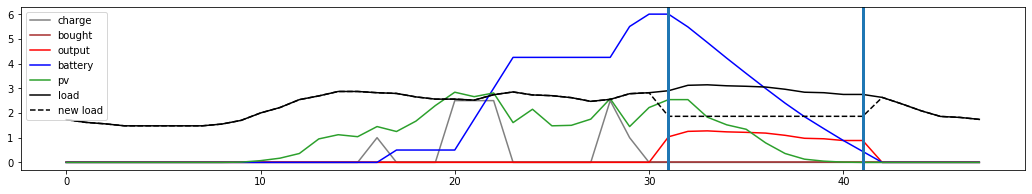

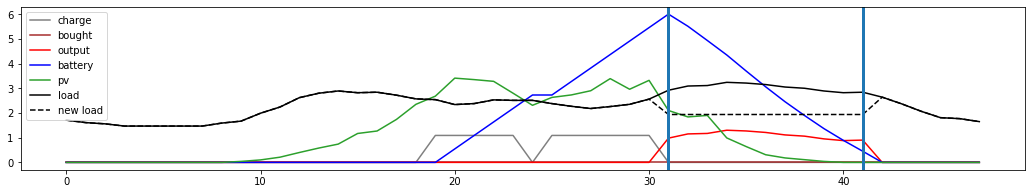

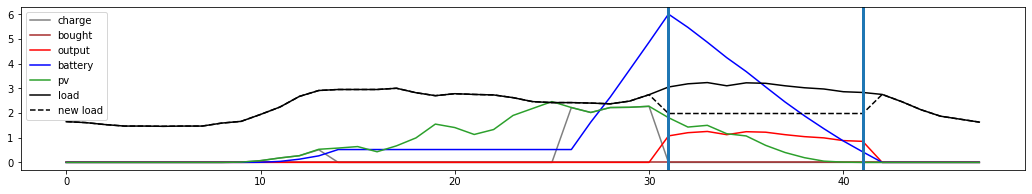

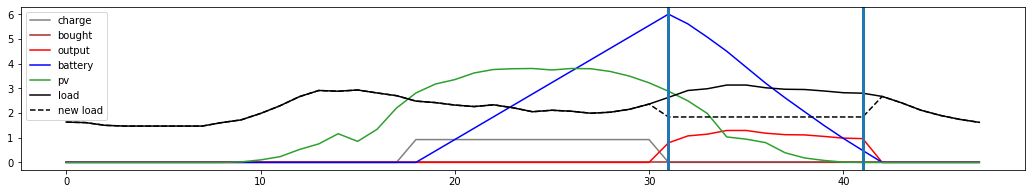

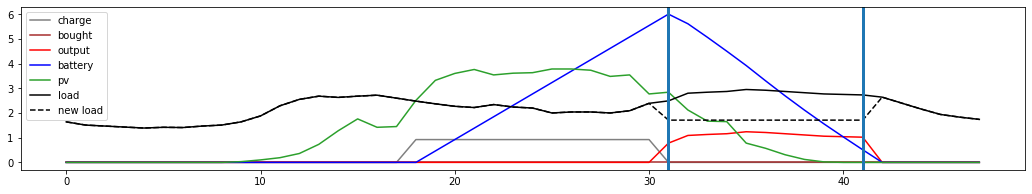

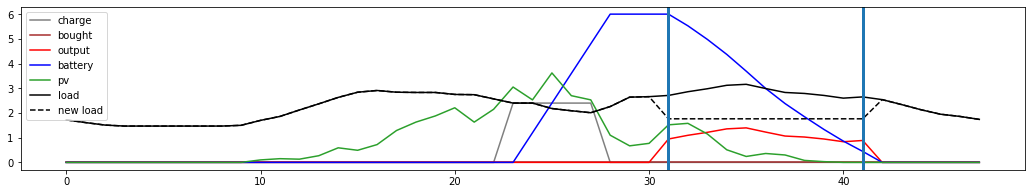

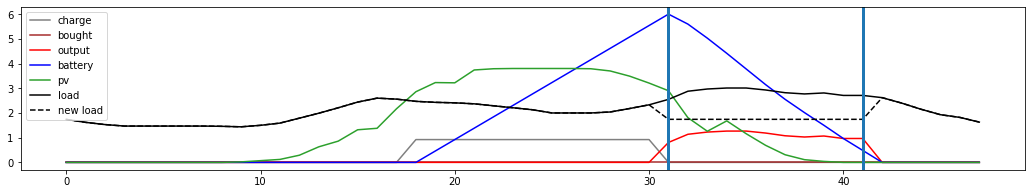

In [399]:
result = np.zeros((48*7,1))

for D in range(7):
    d = 7-D
    if d > 1:
        # last week
        load_d = list(demand['demand_MW'].iloc[-(48*d+48*7):-(48*d-48+48*7)].values)
        pv_d   = list(solar['pv_power_mw'].iloc[-(48*d+48*7):-(48*d-48+48*7)].values)
        # actual
        # load_d = list(demand['demand_MW'].iloc[-(48*d):-(48*d-48)].values)
        # pv_d   = list(solar['pv_power_mw'].iloc[-(48*d):-(48*d-48)].values)
        result[D*48:D*48+48,0:1] = optimize_day(load_d,pv_d,D+1)
    else:
        # last week
        load_d = list(demand['demand_MW'].iloc[-(48*d+48*7):-(48*d-48+48*7)].values)
        pv_d   = list(solar['pv_power_mw'].iloc[-(48*d+48*7):-(48*d-48+48*7)].values)
        # actual
        # load_d = list(demand['demand_MW'].iloc[-48:].values)
        # pv_d   = list(solar['pv_power_mw'].iloc[-48:].values)
        result[D*48:D*48+48,0:1] = optimize_day(load_d,pv_d,D+1)
        
solution['charge_MW'] = result
solution.to_csv('BatteryScheduling.csv',index=False)

<h1>Checking model performance</h1>

<h2>load prediction looks good</h2>

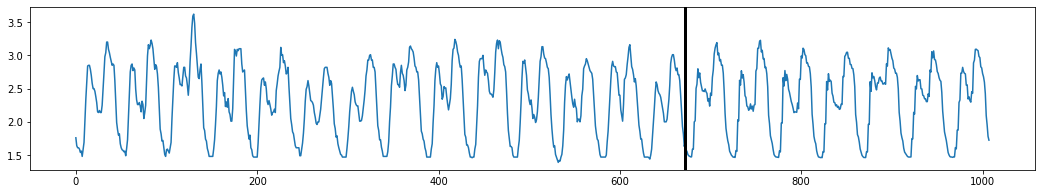

In [397]:
fig = mplt.figure(figsize=(18,3))
mplt.plot(demand['demand_MW'].iloc[-48*21:].values)
mplt.axvline(x=48*14,linewidth=3,c='black')

<h2>power prediction: needs improvement</h2>

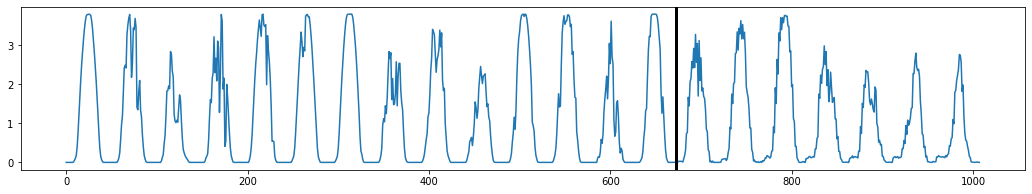

In [398]:
fig = mplt.figure(figsize=(18,3))
mplt.plot(solar['pv_power_mw'].iloc[-48*21:].values)
mplt.axvline(x=48*14,linewidth=3,c='black')

<h1>Checking nans</h1>

In [ ]:
is_NaN = solar.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = solar[row_has_NaN]

print(rows_with_NaN)

<h1>Example of gurobi</h1>

In [454]:
import gurobipy
# installed in c/user/anaconda3
# license in c/user/ashutosh/gurobi

#  maximize
#        x +   y + 2 z
#  subject to
#        x + 2 y + 3 z <= 4
#        x +   y       >= 1
#        x, y, z binary

import gurobipy as gp
from gurobipy import GRB

try:

    # Create a new model
    m = gp.Model("mip1")

    # Create variables
    x = m.addVar(vtype=GRB.BINARY, name="x")
    y = m.addVar(vtype=GRB.BINARY, name="y")
    z = m.addVar(vtype=GRB.BINARY, name="z")

    # Set objective
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
    m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

    # Add constraint: x + y >= 1
    m.addConstr(x + y >= 1, "c1")

    # Optimize model
    m.optimize()

    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))

    print('Obj: %g' % m.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Academic license - for non-commercial use only - expires 2021-03-30
Using license file C:\Users\Ashutosh\gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0xf43f5bdf
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
x 1
y 0
z 1
Obj: 3
